In [1]:
from dataset import PairedDatasetDouble
pd = PairedDatasetDouble('In/0', 'In/1', 'Out_New', 200)

Length of x_train 0 files: 943
Length of x_train 1 files: 943
Length of y_train files: 943
Item 0 with max: 3482 and min: -2180
Normalized item 0 with max: 1.0 and min: 0.0
Item 1 with max: 1681 and min: -1108
Normalized item 1 with max: 1.0 and min: 0.0
Item 2 with max: 5660 and min: -2212
Normalized item 2 with max: 1.0 and min: 0.0
Item 3 with max: 3564 and min: -1221
Normalized item 3 with max: 1.0 and min: 0.0
Item 4 with max: 3452 and min: -2218
Normalized item 4 with max: 1.0 and min: 0.0
Item 5 with max: 3378 and min: -2213
Normalized item 5 with max: 1.0 and min: 0.0
Item 6 with max: 3744 and min: -2186
Normalized item 6 with max: 1.0 and min: 0.0
Item 7 with max: 3495 and min: -2201
Normalized item 7 with max: 1.0 and min: 0.0
Item 8 with max: 1730 and min: -1078
Normalized item 8 with max: 1.0 and min: 0.0
Item 9 with max: 3420 and min: -1118
Normalized item 9 with max: 1.0 and min: 0.0
Item 10 with max: 3547 and min: -2167
Normalized item 10 with max: 1.0 and min: 0.0
Item 

In [2]:
!conda install -y tensorflow-gpu"=>2.1.0"

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pandas==1.0.1=py36h0573a6f_0
  - defaults/noarch::jupyterlab==1.2.6=pyhf63ae98_0
  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::python-language-server==0.31.7=py36_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::nb_conda==2.2.1=py36_0
  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/noarch::anaconda-project==0.8.4=py_0
  - defaults/linux-64::nbconvert==5.6.1=py36_0
  - defaults/linux-64::h5py==2.10.0=py36h7918eee_0
  - defaults/linux-64::bokeh==1.4.0=py36_0
  - defaults/noarch::jupyter

In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

double_model = load_model('dual_model_final.h5')

with open('model_arch.json', 'r') as f:
    single_model = model_from_json(f.read())
    
single_model.load_weights('model_weights.h5')
print("Single and Double AE Models Loaded")

Single and Double AE Models Loaded


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import numpy.ma as ma

def extract_slice_mask(slice):

    ret, thresh = cv.threshold(slice, 0.1, 1, cv.THRESH_BINARY)
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(thresh.astype('uint8'))

    max = stats[1, 4]
    largest_index = 1

    for k in np.delete(np.unique(labels_im), 0):

        size = stats[k, 4]
        if (size > max):

            max = size
            largest_index = k

    mask = ma.masked_not_equal(labels_im, largest_index)
    return mask

def extract_lung_mask(volume, size = 128):

    slices = []

    for i in range(0, size):

        masked_slice = extract_slice_mask(volume[i])
        slices.append(masked_slice)

    slices = np.array(slices)
    return slices

def tpfp(truth, prediction):

    h, w, l = truth.shape[0], truth.shape[1], truth.shape[2]

    tp = np.zeros(truth.shape)
    fp = np.zeros(truth.shape)
    fn = np.zeros(truth.shape)
    tn = np.zeros(truth.shape)

    truth_mask = extract_lung_mask(truth)
    pred_mask = extract_lung_mask(prediction)

    for i in range(0, h):

        for j in range(0, w):

            for k in range(0, l):

                if (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 1):

                    tp[i, j, k] = 1

                elif (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 0):

                    fn[i, j, k] = 1

                elif (truth_mask[i, j, k] == 0 and pred_mask[i, j, k] == 1):

                    fp[i, j, k] = 1

                else:

                    tn[i, j, k] = 1

    tp = ma.masked_values(tp * 100, 0)
    fp = ma.masked_values(fp * 50, 0)
    fn = ma.masked_values(fn, 0)
    
    prdd = pred_mask[64]
    trdd = truth_mask[64]

    return tp, fp, fn


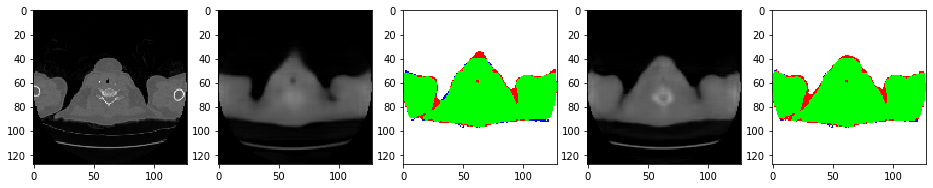

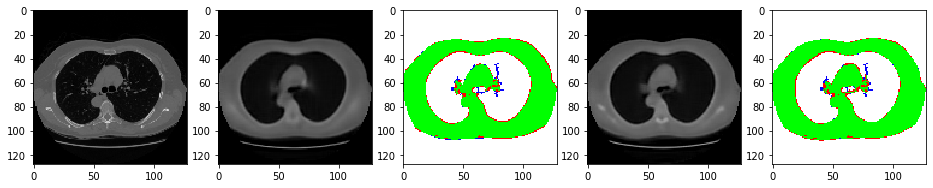

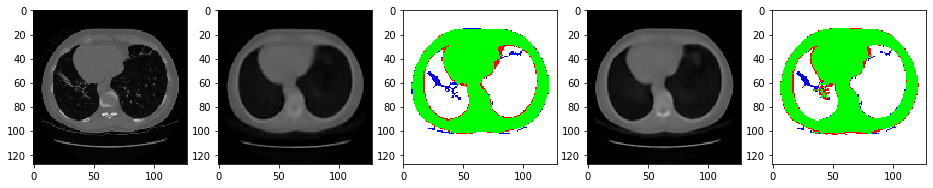

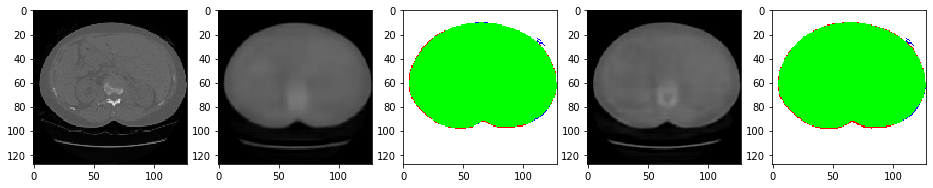

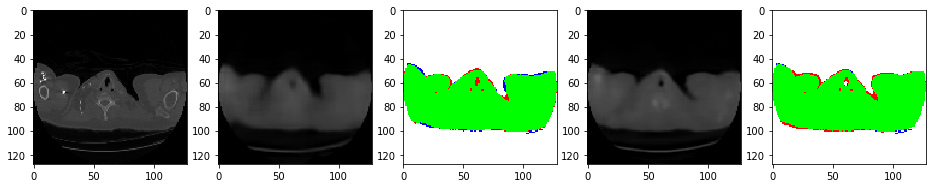

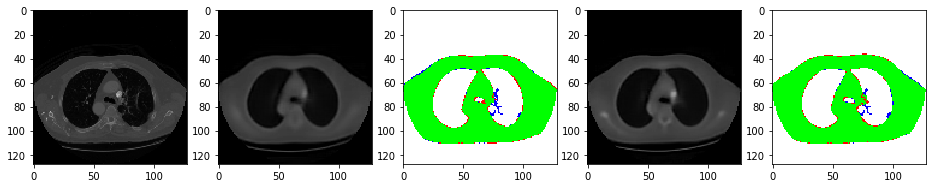

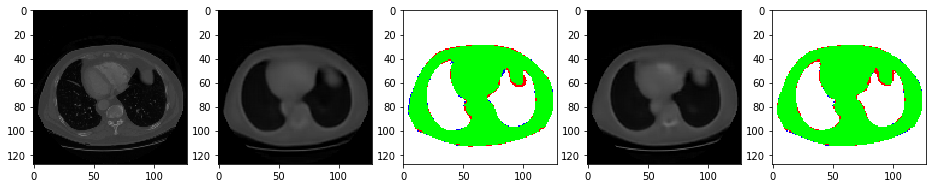

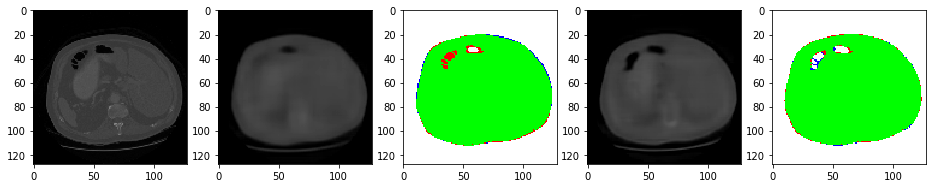

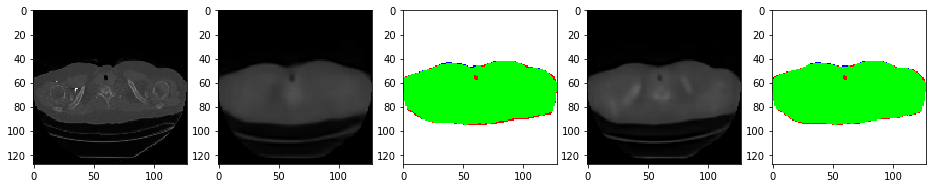

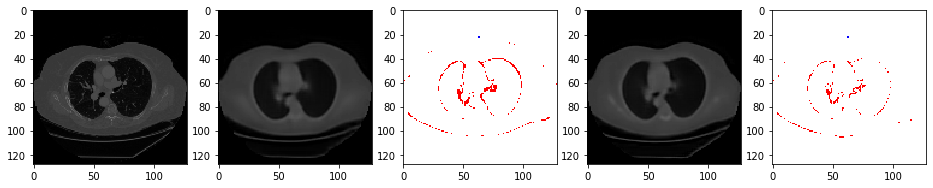

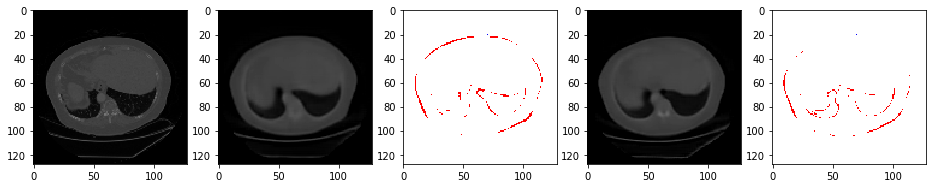

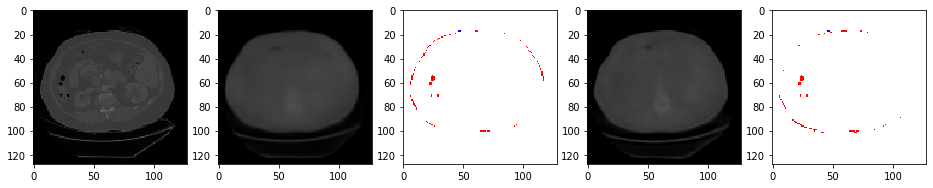

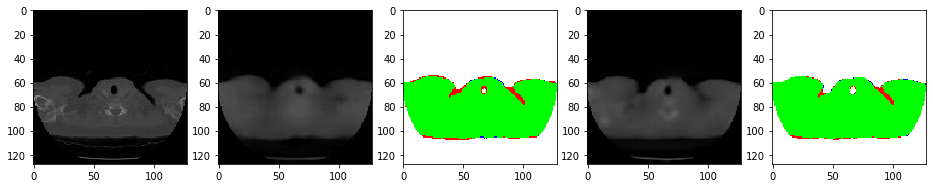

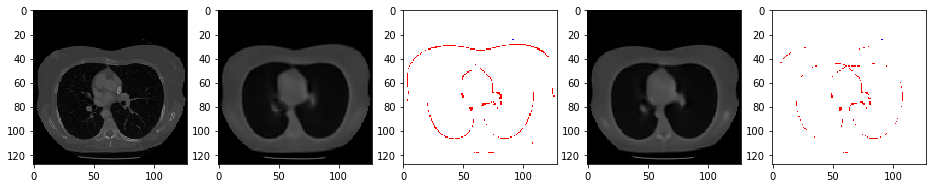

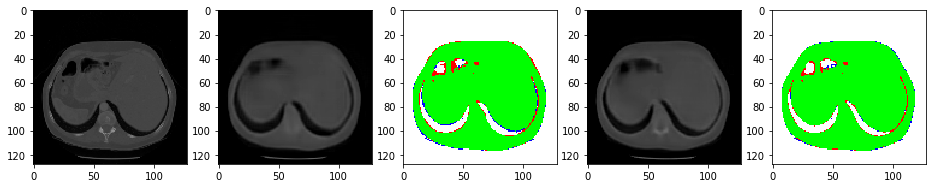

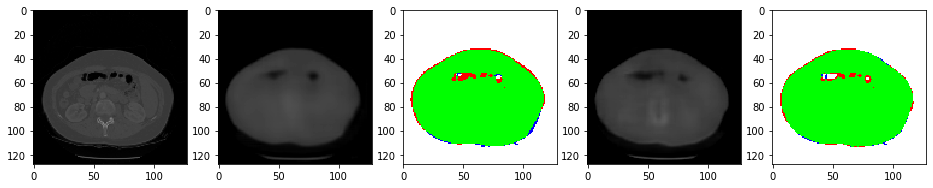

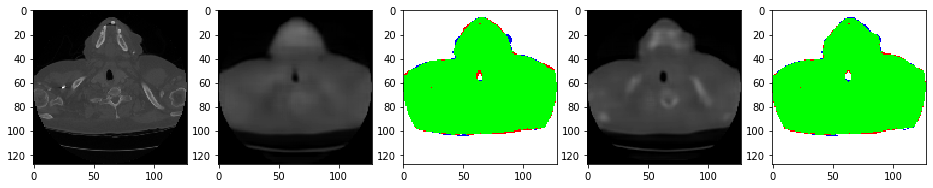

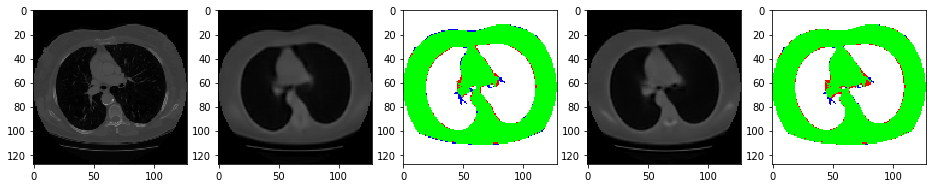

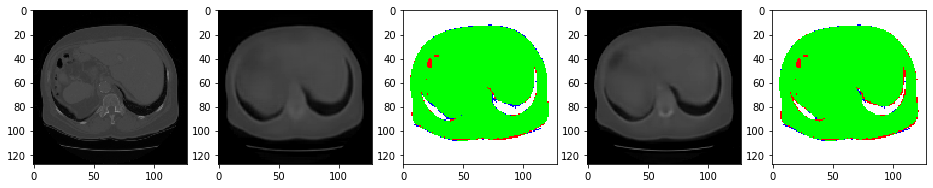

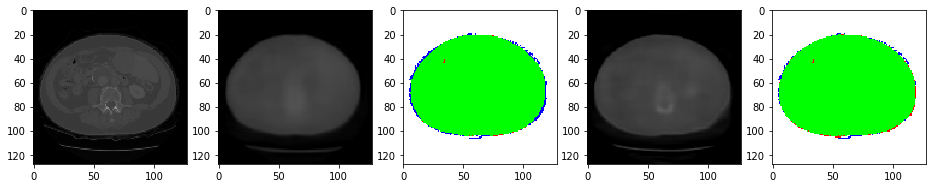

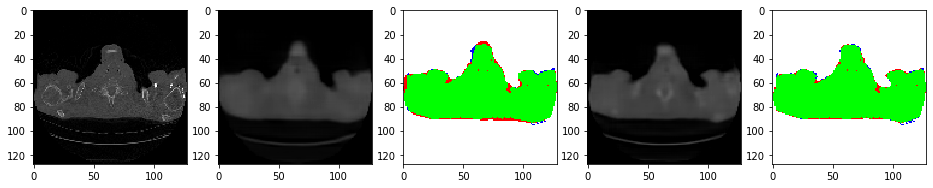

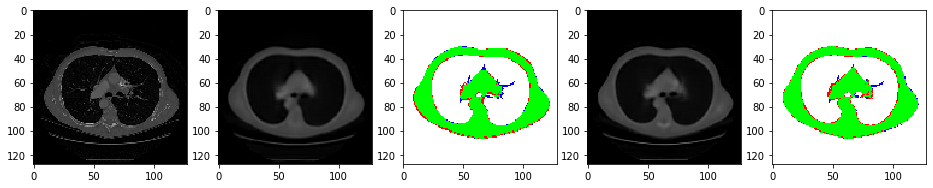

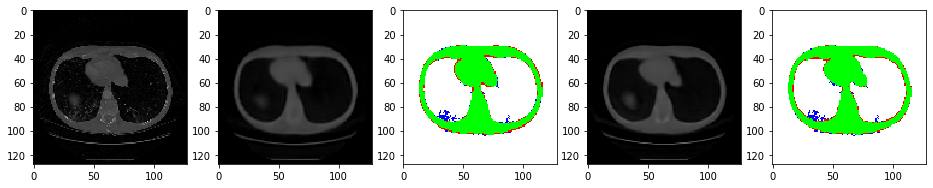

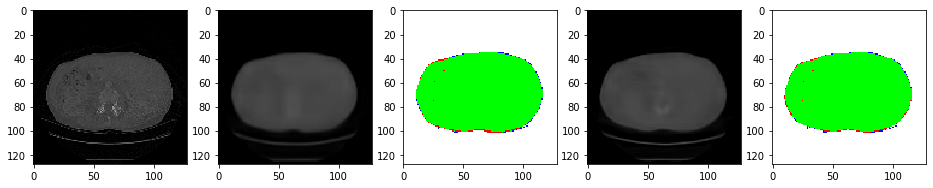

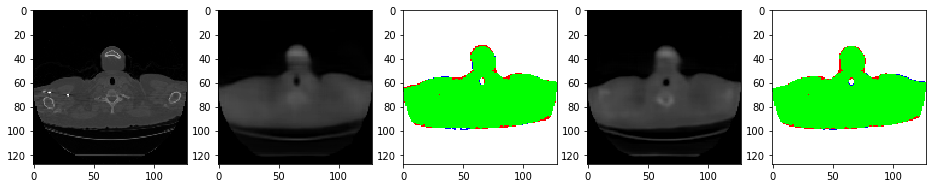

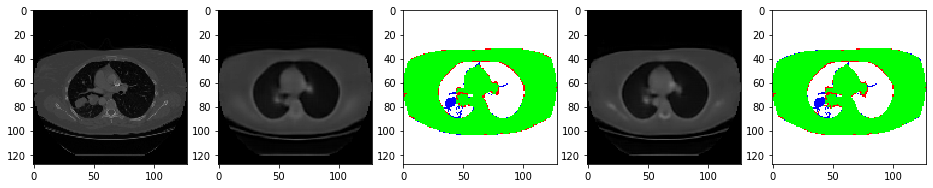

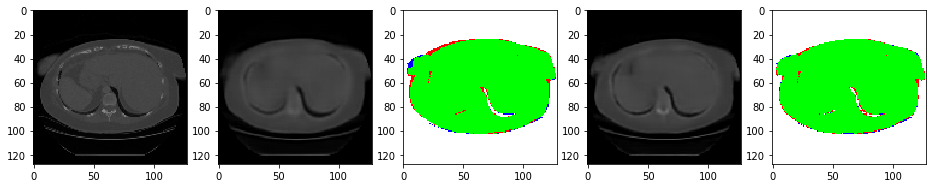

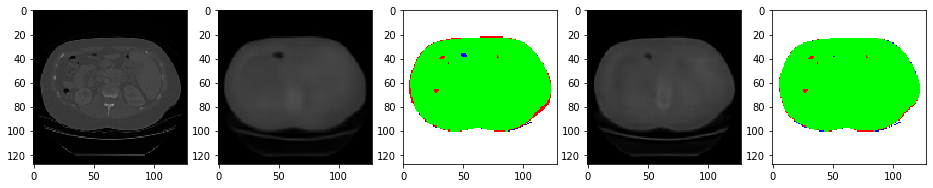

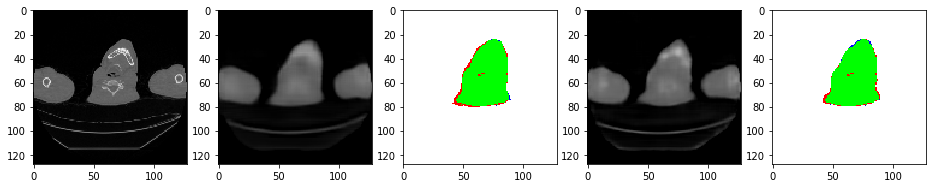

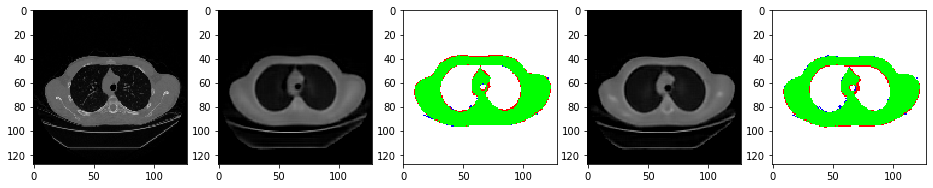

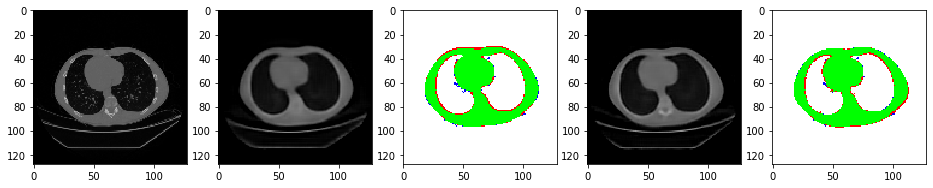

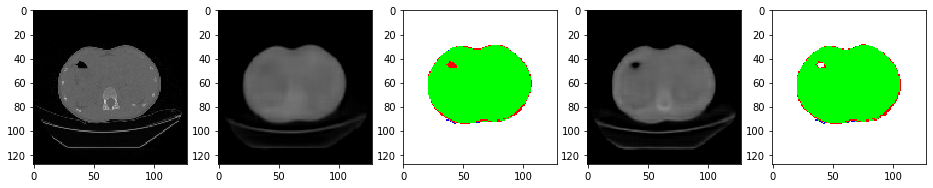

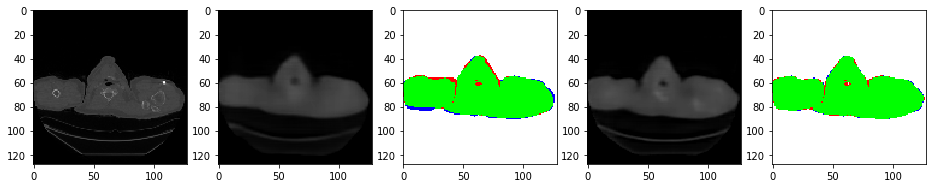

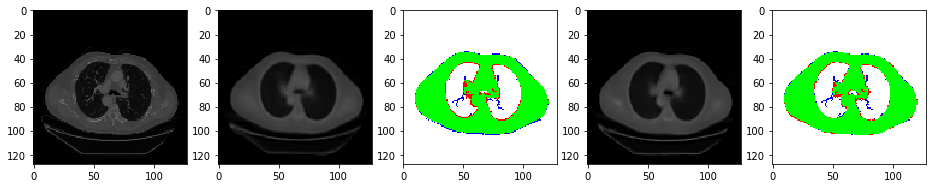

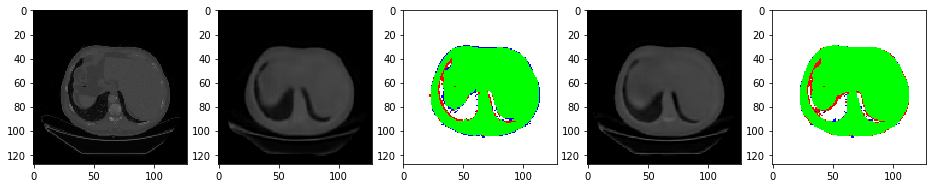

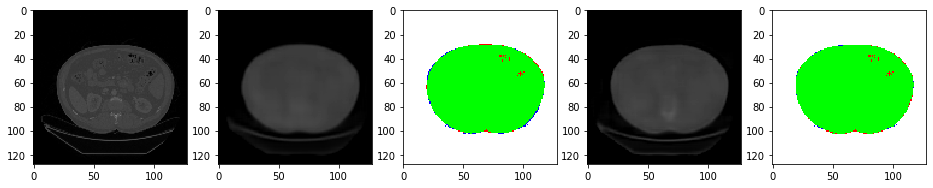

In [17]:
for i in range(1, 10):
    
    input_1 = pd.x_train_0[i]
    input_2 = pd.x_train_1[i]
    
    input_1 = np.reshape(input_1, (1, 1024, 1024, 1))
    input_2 = np.reshape(input_2, (1, 1024, 1024, 1))
    
    output_single = single_model.predict(input_1)
    output_double = double_model.predict([input_1, input_2])
    
    output_single = np.reshape(output_single, (128, 128, 128))
    output_double = np.reshape(output_double, (128, 128, 128))
    
    original = pd.y_train[i]
    
    s_tp, s_fp, s_fn = tpfp(original, output_single)
    d_tp, d_fp, d_fn = tpfp(original, output_double)
    
    slice_depths = [0, 48, 92, 127]
    
    for k in slice_depths:
    
        f = plt.figure(figsize = (16, 10))

        f.add_subplot(1, 5, 1)
        plt.imshow(original[k], cmap = 'gray', vmin = 0, vmax = 1)

        f.add_subplot(1, 5, 2)
        plt.imshow(output_single[k], cmap = 'gray', vmin = 0, vmax = 1)

        f.add_subplot(1, 5, 3)
        plt.imshow(s_tp[k], cmap = 'brg', vmin = 0.1)
        plt.imshow(s_fp[k], cmap = 'brg', vmin = 0.1, vmax = 100)
        plt.imshow(s_fn[k], cmap = 'brg', vmin = 0.1, vmax = 90)

        f.add_subplot(1, 5, 4)
        plt.imshow(output_double[k], cmap = 'gray', vmin = 0, vmax = 1)

        f.add_subplot(1, 5, 5)
        plt.imshow(d_tp[k], cmap = 'brg', vmin = 0.1)
        plt.imshow(d_fp[k], cmap = 'brg', vmin = 0.1, vmax = 100)
        plt.imshow(d_fn[k], cmap = 'brg', vmin = 0.1, vmax = 90)   

        plt.show()

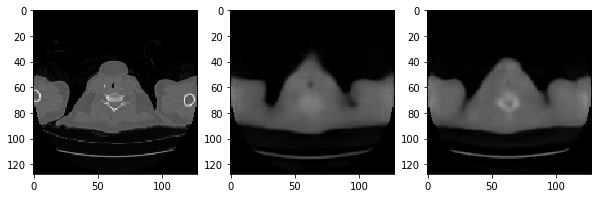

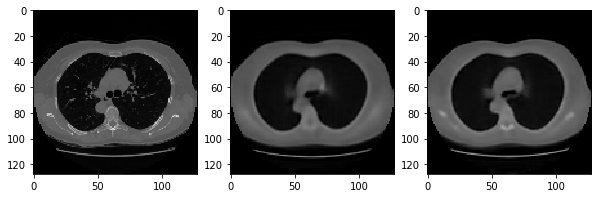

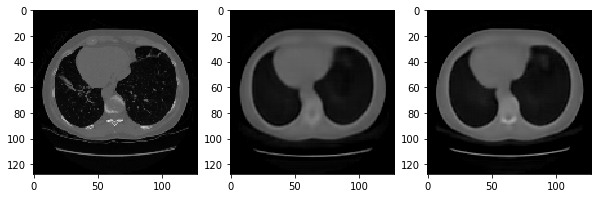

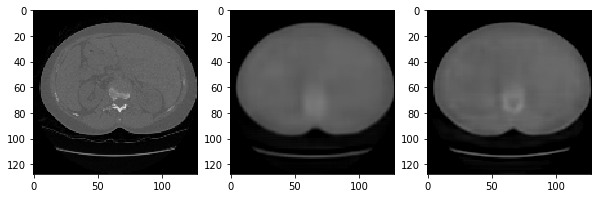

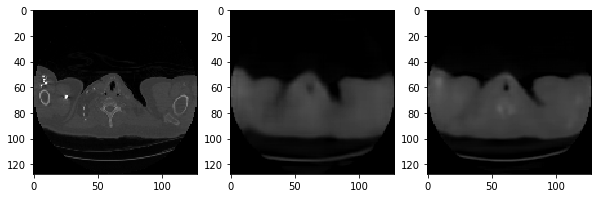

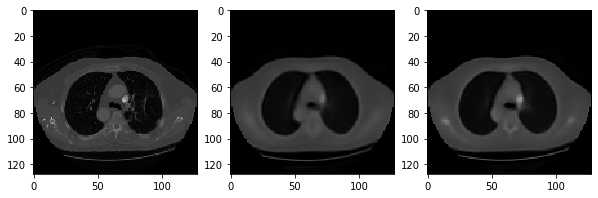

In [ ]:
for i in range(1, 10):
    
    input_1 = pd.x_train_0[i]
    input_2 = pd.x_train_1[i]
    
    input_1 = np.reshape(input_1, (1, 1024, 1024, 1))
    input_2 = np.reshape(input_2, (1, 1024, 1024, 1))
    
    output_single = single_model.predict(input_1)
    output_double = double_model.predict([input_1, input_2])
    
    output_single = np.reshape(output_single, (128, 128, 128))
    output_double = np.reshape(output_double, (128, 128, 128))
    
    original = pd.y_train[i]
    
    
    slice_depths = [0, 48, 92, 127]
    
    for k in slice_depths:
    
        f = plt.figure(figsize = (10, 7))

        f.add_subplot(1, 3, 1)
        plt.imshow(original[k], cmap = 'gray', vmin = 0, vmax = 1)

        f.add_subplot(1, 3, 2)
        plt.imshow(output_single[k], cmap = 'gray', vmin = 0, vmax = 1)


        f.add_subplot(1, 3, 3)
        plt.imshow(output_double[k], cmap = 'gray', vmin = 0, vmax = 1)


        plt.show()